# Gaussian Processes Regression

Here we will develop the necessary functions to test the new model.

## Load libraries

The easiest way to do it will be to load the required libraries from the beginning to work with matrices (as a mathematician would do it).
We'll figure out how to make the algorith numerically stable and efficient (as a computer scientist would do) later on if we have enough time.

In [0]:
import numpy as np # To work with arrays and matrices. It also has some maths operations.
import pandas as pd # To read the data from the internet.
import matplotlib.pyplot as plt # To visualise the results.
from sklearn.linear_model import LinearRegression # To perform a simple linear regression

## The regression problem

Recall that the problem we are trying to solve is to find a function $f\colon\mathbb R\to\mathbb R$ that helps us explain our variable $y$ with certain error. We can think of this in the following way:

$$y_k = f(x_k) + \varepsilon_k.$$

Where $y_k$ is the $k$-th observation, $f$ is the function that we are trying to find, $x_k$ is the value of the auxiliary independent variable for the $k$-th observation, and $\varepsilon_k$ is the $k$-th error.

As we've seen before, we would like the error not to deviate much from the Normal distribution and we want the errors to be independent from each other. So, the assumption we will be making is that

$$y_k|f,x_k,\sigma^2\sim N(f(x_k),\sigma^2).$$

The hyperparameter $\sigma$ should depend on the sample size and the logit transformation. The maths behind this should not be very complicated but will be done in another report.

## Bayesian statistics

The point of the Bayesian approach to statistics is that we can always say something about the parameters we are studying with a certain degree of certainty (or rather uncertainty). Even if we have no data whatsoever, we denote our beliefs of the parameters by a *prior* distribution.

In our case, we will set the *prior* as a Gaussian Process with mean function identically $0$ and covariance function $k\colon\mathbb R^2\to(0,1]$ given by $$k(x,x')=\exp\left\{-\frac{(x-x')^2}{\ell^2}\right\} .$$

That is $$f|\mathbf x\sim\mathrel{GP}(\mathbb0,k).$$

The parameter $\ell$ should be a positive number that we can interpret as how autocorrelated the series is. If $\ell\to0$ then $k(x,x')\to0$ meaning that the series is pretty much uncorrelated and today doesn't depend on what happened yesterday. This sounds like a stretch, so we might want to have a positive value of $\ell$. If $\ell\to\infty$ then $k(x,x')\to 1$ meaning all values are the same making the function constant and that is another extreme.

We need a finite value of $\ell$ greater than 0. This is a hyperparameter that we need to tune. We could in principle add a prior distribution to this parameter as well, but we'll keep things simple for now and just fix it. We'll start with 1, but we need a function that calculates this kernel.


In [0]:
# You need to complete this function as the formula above.
# x1 and x2 are just two real numbers.
import numpy as np
def covariance_kernel(x1, x2, l=1):
  k = 0
  k = np.exp(-((x1-x2)**2/l**2))
  return(k)

The next thing is observing actual data. Let's call this data $y_1,y_2\ldots,y_n$ with corresponding covariate values $x_1,x_2,\ldots,x_n$. The way in which we *update our beliefs* on the parameters is via *Bayes's Theorem*. stating that:

$$p(f|\mathbf y,\mathbf x,\sigma^2)\propto p(\mathbf y|f,\mathbf x,\sigma^2)p(f|\mathbf x).$$

Fortunately, the maths are all done, as we may see in __[this document](https://dukespace.lib.duke.edu/dspace/bitstream/handle/10161/16871/Futoma_duke_0066D_14502.pdf?sequence=1)__ and we'll be writing the script as we move along.

## Read the data

We now will be in process of trying our new model with actual data. I saved the data in my __[Git Hub profile](https://github.com/Duhart/Gaussian_Process_Regression)__ and will eventually save this notebook over there. 

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/Duhart/Gaussian_Process_Regression/master/data.csv")
df.head()

,date,awareness,tvr
0,1,0.40,5
1,2,0.41,0
2,3,0.31,20
3,4,0.40,780
4,5,0.45,610


Now I am going to set it up as a numpy arrays so that everything fits in our work flow so far.

In [0]:
pre_x = np.array(df.tvr,)
pre_y = np.array(df.awareness,)

## Data transformations

I will then copy your functions to calculate the logit of the awareness (note that I reduced the dependency of the *math* library only to *numpy* in order to find the logarithm) that will be our variable $y$, find the best decay rate for the adstocks and calculate those adstocks to be our variable $x$.

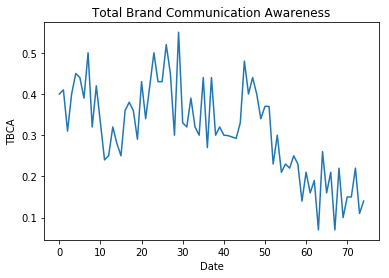

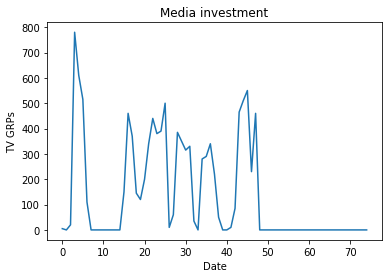

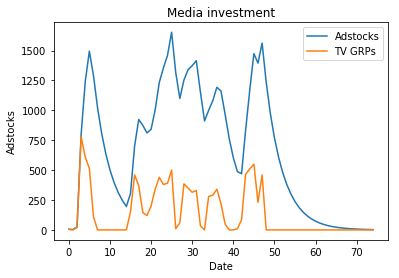

In [5]:
# This function receives an array as input and a retention rate
# it gives back an array of the same size as stocks with 
# the adstocks of the array with the corresponding rate.
def adstocks(stocks, decay):
    adStocksArray = []
    adStocksArray.append(stocks[0])
    for counter in range(1, len(stocks)):
        adStocks = adStocksArray[counter - 1] * decay + stocks[counter]
        adStocksArray.append(adStocks)
    return(adStocksArray)

# This function receives an arraw and gives back an array of the same size
# as Awareness with the logit of the variable.
def find_logit(Awareness):
    Logit = []
    for counter in range(0,len(Awareness)):
        if Awareness[counter] < 0.00001:
            Logit.append(np.log(0.00001/(1-0.00001)))
        elif Awareness[counter] > 0.99999:
            Logit.append(np.log(0.99999/(1-0.99999)))       
        else:
            Logit.append(np.log(Awareness[counter]/(1-Awareness[counter]))) 
    return(Logit)

# This functions finds the best retention rate within the values of limits
# for the adstocks of x by
# maximising the correlation with y.
# This function requires the following inputs:
# x: an array
# y: an array the same length as x.
# limits: a tuple (a, b) with two elements 0< a < b < 1.
# step: the length from elements in the grid.
def find_rate(x, y, limits = (0,0.8), step = 0.01):
  grid = np.arange(limits[0],limits[1],step)
  best = -1
  best_rate = 0
  for i in range(0, len(grid)):
      adStocks = adstocks(x,grid[i])
      correlation =  np.corrcoef(adStocks, y)[0,1]
      if correlation > best:
          best_rate = grid[i]
          best = correlation
          bestAds = adStocks
  return((best_rate, bestAds))

# We now use our functions
# Find the rate and adstocks to use as covariate
y = np.array(find_logit(pre_y))
r, x = find_rate(pre_x, y, (0,0.8), 0.01)
x = np.array(x)
x.shape = (len(pre_y),1)


plt.plot(pre_y)
plt.title('Total Brand Communication Awareness')
plt.xlabel('Date')
plt.ylabel('TBCA')
plt.show()

plt.plot(pre_x)
plt.title('Media investment')
plt.xlabel('Date')
plt.ylabel('TV GRPs')
plt.show()

plt.plot(x, label = 'Adstocks')
plt.plot(pre_x, label = 'TV GRPs')
plt.title('Media investment')
plt.xlabel('Date')
plt.ylabel('Adstocks')
plt.legend(loc='upper right') 
plt.show()

## First model: Simple Linear Regression

We now have the data as we need it to proceed to modelling. We will first do a simple linear regression to have something to compare with our proposed model.

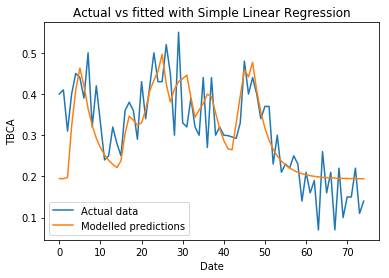

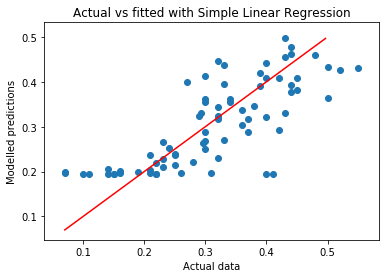

In [6]:
# Here we create an instance of an object of the class LinearRegression
# This is an example of object oriented programming.
# I changed the named from model to slr that stands for
# simple linear regression
slr = LinearRegression()

# We load our pre-worked data
slr.fit(x,y)

# Calculate the predicted values
predictedY = slr.intercept_ + slr.coef_*x

# Define the inverse of the logit function
def sigmoid(x):
  y = 1/(1 + np.exp(-x))
  return(y)

# Get predicted values in the original scales
tbca_slr = sigmoid(predictedY)                               #Television Brand Communication Awareness

# Plot results
plt.plot(pre_y, label = 'Actual data')
plt.plot(tbca_slr, label = 'Modelled predictions')
plt.title('Actual vs fitted with Simple Linear Regression')
plt.xlabel('Date')
plt.ylabel('TBCA')
plt.legend(loc='lower left') 
plt.show()

our_plot = plt.scatter(pre_y,tbca_slr)
plt.title('Actual vs fitted with Simple Linear Regression')
plt.xlabel('Actual data')
plt.ylabel('Modelled predictions')
plt.plot([np.min([np.min(tbca_slr),np.min(pre_y)]), np.min([np.max(tbca_slr),np.max(pre_y)])], [np.min([np.min(tbca_slr),np.min(pre_y)]), np.min([np.max(tbca_slr),np.max(pre_y)])], 'k-', color = 'r')
plt.show()

## Second model: Gaussian Process Regression

Here comes the interesting bit. I will be explaining what we need to calculate and you need to be scripting what I need to happen.
Here we go...

We first need to set $\mathbf x$ and $\mathbf y$ as vertical vectors in $\mathbb R^n$. I'll do that one. 

In [0]:
y.shape = (len(y),1)

You had previously defined the function *covariance_kernel* before which is the code for the function $k\colon\mathbb R\to\mathbb R$. With this function, we need to calculate the following two matrix functions in terms of this one.

The first one receives as inputs a number and a vector (most likely the covariates as we will later see), and it's defined in the following way:

$$\mathbf k\colon\mathbb R\times\mathbb R^n\to\mathbb R^n$$

$$\mathbf k(x,\mathbf x) = \left[\begin{array}{c}
k(x,x_1)\\
k(x,x_2)\\
\vdots\\
k(x,x_n)
\end{array}
\right].$$

In [0]:
# Finish the code according to the previous formula.
# x_num is just a number.
# x_vec is an array of shape (n,1)
# You must return a vector res with the same shape as x_vec
import numpy as np
def vector_k(x_num,x_vec, l=1):
  n = x_vec.shape[0]
  res = np.zeros((n,1))
  for i in range(0, n):
    res[i,0] = covariance_kernel(x_num, x_vec[i,0] , l)

  return(res)


The second function gives a matrix as a result. So it's very likely you'll need a nested loop to generate it.

$$\mathbf K\colon\mathbb R^m\times\mathbb R^n\to\mathbb R^{m\times n}$$

$$\mathbf K(\mathbf x,\mathbf y) = \left[\begin{array}{cccc}
k(x_1,y_1) & k(x_1,y_2) & \cdots & k(x_1,y_n)\\
k(x_2,y_1) & k(x_2,y_2)& \cdots & k(x_2,y_n)\\
\vdots & \vdots & \ddots & \vdots\\
k(x_m,y_1) & k(x_m,y_2) & \cdots & k(x_m,y_n)
\end{array}
\right].$$

In [0]:
# Again, finish the job according to the formulas above. 
# x is an array of shape (m,1)
# y is an array of shape (n,1)
# you must return an array of shape (m,n)
def matrix_k(x,y, l=1):
  # Initialise result
  n = y.shape[0]
  m = x.shape[0]
  res = np.zeros((m,n))
  for i in range(0,m):
    for j in range(0,n):
      res[i,j] = covariance_kernel(x[i,0], y[j,0]  , l)

  return(res)

If you're ok so far we're half way there. We will now calculate the posterior probability of $f$ evaluated at each of the covariate values. Since all distributions here are Normal, it's natural to expect a Normal posterior.

$$ f(x_k)|\mathbb y, \sigma^2 \sim N(\mu(x_k),\nu(x_k)).$$

Where

$$ \mu\colon\mathbb R\to\mathbb R$$

$$ \mu(x) = \mathbf k(x,\mathbf x)^T(K(\mathbf x, \mathbf x) + \sigma^2I)^{-1}\mathbf y.$$

Note that in the formula there's an $x$, the point where we are evaluating; and $\mathbf x$, the vector of original values of the covariate. There are also three letter k's: $k$, the *covariance_kernel* function; $\mathbf k$, the *vector_k* function; and $K$, the *matrix_k* function. Be sure of when you're using which.

I also mention a matrix $I$. This is the __[identity matrix](https://en.wikipedia.org/wiki/Identity_matrix)__ which is very easy to generate in Python. I have already calculated it down below.

In [0]:
# Complete the code. 
# This is a hard one, we need to invert a matrix!
# This is simply something no one will ever do on a computer.
# We are going to do it anyways, the data is quite noble so we shouldn't
# have any problems.
# x is a real number.
# x_vec is an array of shape (n,1)
# y_vec is an array of the same shape as x_vec
# sigma is a positive number.
def mu(x, x_vec, y_vec, sigma, l=1):
  n = x_vec.shape[0]
  m = y_vec.shape[0]
  I = np.identity(n)
  res = np.matmul(np.matmul(np.transpose(vector_k(x,x_vec,l)),np.linalg.inv(matrix_k(x_vec,x_vec,l) + sigma**2 * I)),y_vec)
  return(res[0,0])

Once you were able to solve the above coding, the following goes in the same difficulty grade.
$$\nu:\mathbb R\to[0,\infty)$$
$$\nu(x) = k(x,x) - \mathbf k(x,\mathbf x)^T(K(\mathbf x, \mathbf x) + \sigma^2I)^{-1}\mathbf k(x,\mathbf x).$$

In [0]:
# Complete the code! Nearly there!
# x is a real number.
# x_vec is an array of shape (n,1)
# sigma is a positive number.
def nu(x,x_vec,sigma, l=1):
  n = x_vec.shape[0]
  I = np.identity(n)
  res = covariance_kernel(x,x, l)- np.matmul(np.matmul(np.transpose(vector_k(x,x_vec,l)),np.linalg.inv(matrix_k(x_vec,x_vec,l) + sigma**2 * I)),vector_k(x,x_vec,l))
  return(res[0,0])

We will now define a couple of functions to evaluate the previous two $\mu$ and $\nu$ in our original data points. This is where we bring the *Gaussian Process Regression* to life!

In [0]:
def finding_mu(x, x_vec, y_vec, sigma, l):
  mu_array = []
  for i in range(0,len(x)):
    mu_array.append(mu(x[i,0], x_vec, y_vec, sigma, l))
  return mu_array

def finding_vu(x, x_vec, sigma, l):
  v_array = []
  for i in range(0,len(x)):
    v_array.append(nu(x[i,0], x_vec, sigma, l))
  return v_array


And finally run everything.

In [0]:
# These are the hyperparameters sigma and l:
sigma = 0.8
l = 200

# Calculate the posterior along with a 95% probability interval on our observations.
f_posterior = sigmoid(np.array(finding_mu(x,x, y,sigma,l)))
LB = sigmoid(np.array(finding_mu(x,x, y,sigma,l)) - 1.96*np.array(finding_vu(x,x,sigma,l)))
UB = sigmoid(np.array(finding_mu(x,x, y,sigma,l)) + 1.96*np.array(finding_vu(x,x,sigma,l)))

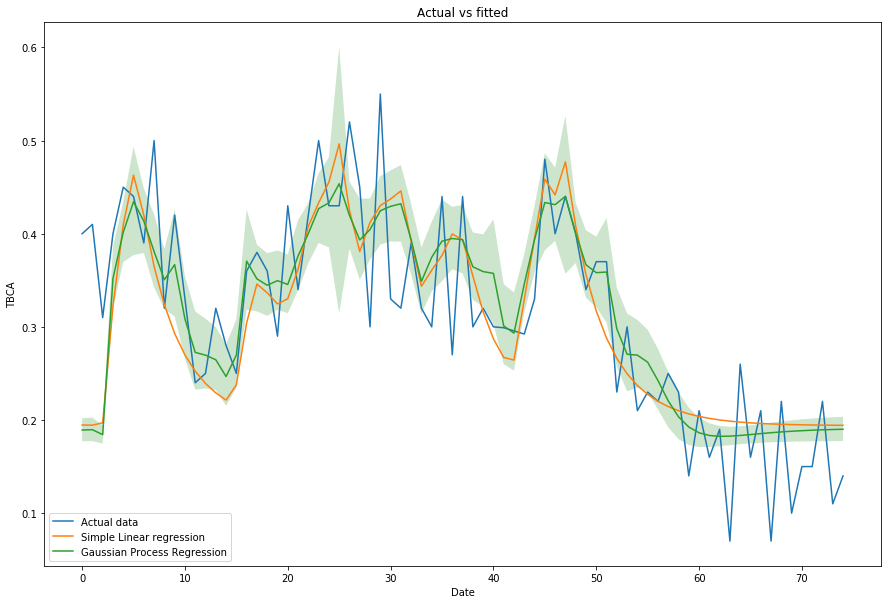

In [41]:
# Plot results
plt.plot(pre_y, label = 'Actual data')
plt.plot(tbca_slr, label = 'Simple Linear regression')
plt.plot(f_posterior, label = 'Gaussian Process Regression')
plt.fill_between(x = range(0,len(pre_x)), y1 = LB, y2 = UB, facecolor = 'green', alpha = 0.2)
plt.title('Actual vs fitted')
plt.xlabel('Date')
plt.ylabel('TBCA')
plt.legend(loc='lower left') 
plt.gcf().set_size_inches(15,10)
plt.show()

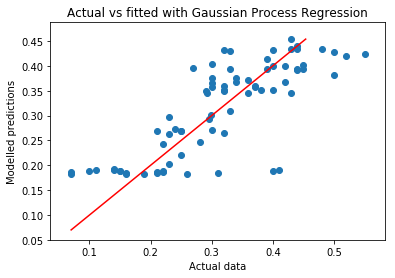

In [42]:
our_plot = plt.scatter(pre_y,f_posterior)
plt.title('Actual vs fitted with Gaussian Process Regression')
plt.xlabel('Actual data')
plt.ylabel('Modelled predictions')
plt.plot([np.min([np.min(f_posterior),np.min(pre_y)]), np.min([np.max(f_posterior),np.max(pre_y)])], [np.min([np.min(f_posterior),np.min(pre_y)]), np.min([np.max(f_posterior),np.max(pre_y)])], 'k-', color = 'r')
plt.show()

## Interpretability

We need to find the derivative with respect to $x$ of $\mu(x)$ which is given by
$$\frac{\partial}{\partial x}\mu(x) = \frac{\partial \mathbf K(x,\mathbf x)}{\partial x}(\mathbf K(\mathbf x,\mathbf x) + \sigma^2I)^{-1}\mathbf y.$$

And the derivative of the matrix is given by
$$\frac{\partial \mathbf K(x,\mathbf x)}{\partial x} = \left(\frac{\partial k(x,x_1)}{\partial x}, \frac{\partial k(x,x_2)}{\partial x},\ldots,\frac{\partial k(x,x_n)}{\partial x} \right).$$

Finally, the derivative of the covariance kernel is given by
$$\frac{\partial k(x,y)}{\partial x} = -\frac{2}{\ell^2}(x-y)k(x,y).$$

We now write functions for all these functions:

In [0]:
# The derivative of the covariance kernel
def dk(x,y,l = 1):
  return(-2/l**2*(x-y)*covariance_kernel(x,y,l))

# The derivative of the 1 row matrix K
def dvecK(x,vec_x,l = 1):
  res = np.zeros((1,len(vec_x)))
  for j in range(0,len(vec_x)):
    res[0,j] = dk(x,vec_x[j,0],l)
  return(res)

# The derivative of mu
def dmu(x,x_vec,y_vec,sigma = 1, l = 1):
  I = np.identity(len(x_vec))
  res = np.matmul(dvecK(x,x_vec,l),np.matmul(np.linalg.inv(matrix_k(x_vec,x_vec,l) + sigma**2 * I),y_vec))
  return(res[0,0])

Now let's see how this look like for different values of $x$:

In [0]:
# Let's have a grid of values for all possible adstocks:
ads = np.arange(0,max(x),step = max(x)/1000)

# Calculate derivative
gaussian_slopes = np.zeros(1000)
for j in range(0,1000):
  gaussian_slopes[j] = dmu(ads[j],x,y,sigma,l)

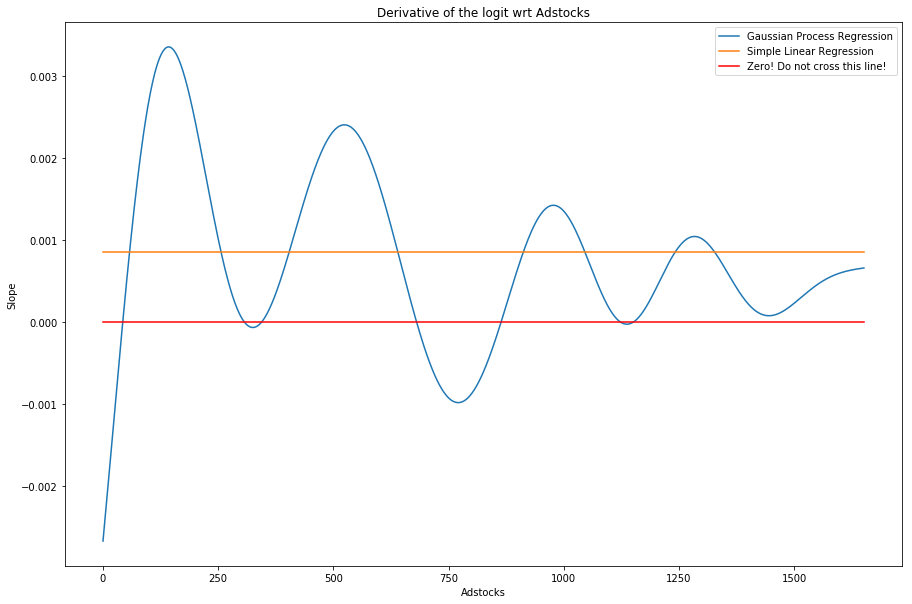

In [61]:
# Plot results
plt.plot(ads,gaussian_slopes, label = 'Gaussian Process Regression')
plt.plot(ads,slr.coef_ * np.ones(1000) ,label = 'Simple Linear Regression')
plt.plot(ads,np.zeros(1000) ,label = 'Zero! Do not cross this line!', color = '#ff0000')
plt.title('Derivative of the logit wrt Adstocks')
plt.xlabel('Adstocks')
plt.ylabel('Slope')
plt.legend(loc='best') 
plt.gcf().set_size_inches(15,10)
plt.show()

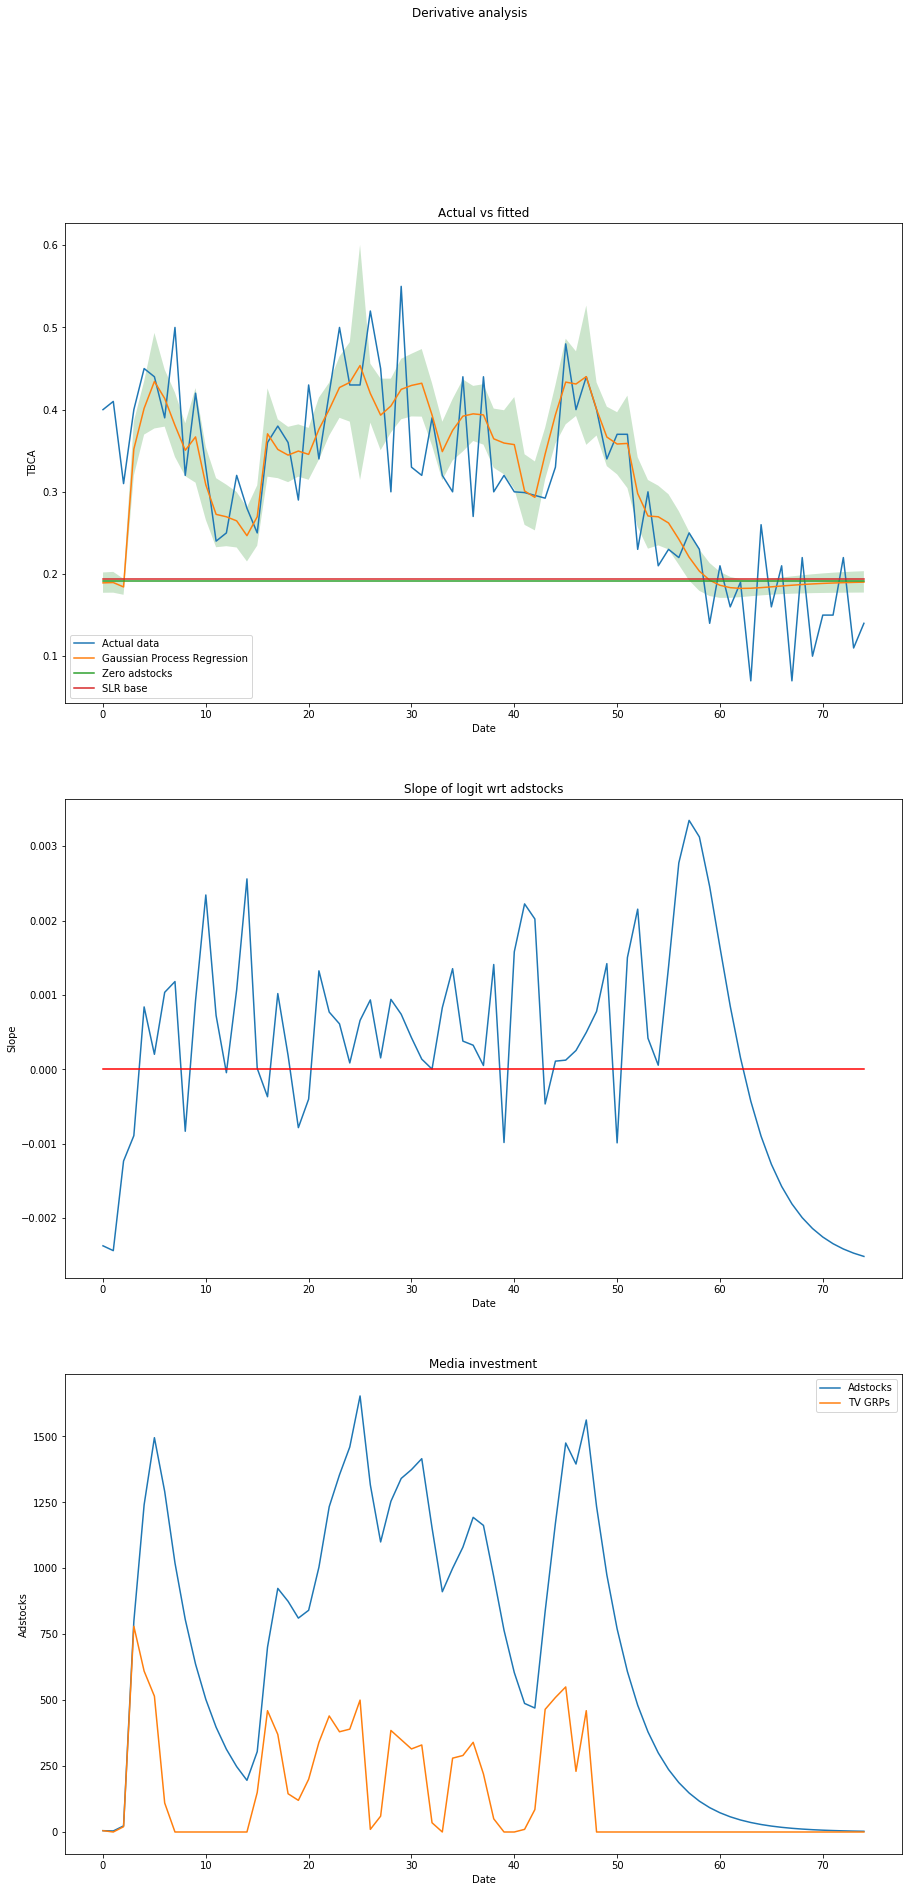

In [60]:
# Plot slope
d = range(0,len(pre_y))

# Calculate derivative and base
gs = np.zeros(len(pre_y))
logit_base = np.zeros(len(pre_y))
for j in range(0,len(pre_y)):
  gs[j] = dmu(x[j,0],x,y,sigma,l)
  logit_base[j] = mu(0,x,y,sigma,l)
  
base = sigmoid(logit_base)


# For subplots
fig, axs = plt.subplots(3)
fig.suptitle('Derivative analysis')
plt.gcf().set_size_inches(15,30)

# Plot results
axs[0].plot(pre_y, label = 'Actual data')
axs[0].plot(f_posterior, label = 'Gaussian Process Regression')
axs[0].plot(base, label = 'Zero adstocks')
axs[0].plot(sigmoid(slr.intercept_*np.ones(len(pre_y))), label = 'SLR base')
axs[0].fill_between(x = range(0,len(pre_x)), y1 = LB, y2 = UB, facecolor = 'green', alpha = 0.2)
axs[0].set_title('Actual vs fitted')
axs[0].set(xlabel='Date',ylabel='TBCA')
axs[0].legend(loc='lower left') 

axs[1].plot(d,gs, label = 'GPR')
axs[1].plot(d,np.zeros(len(d)) ,label = 'Do not cross this line!', color = '#ff0000')
axs[1].set_title('Slope of logit wrt adstocks')
axs[1].set(xlabel='Date',ylabel='Slope')

axs[2].plot(x, label = 'Adstocks')
axs[2].plot(pre_x, label = 'TV GRPs')
axs[2].set_title('Media investment')
axs[2].set(xlabel='Date',ylabel='Adstocks')
axs[2].legend(loc='upper right') 

# Conclusion and next steps

Both parameters, the base (ie: the value of TBCA when the adstocks are 0) and the slope (the derivative of the logit of the TBCA with respect to the adstocks) are very much in line. The slope moves drastically reaching negative values at times (that is one invests more and decrease the TBCA) which may be counterintuitive but it may be because the model flags that there some information missing.

We need to generalise the algorithms to accept more covariates (e.g. adstocks and time, maybe adstocks from competitiors, etc.) and make the algorithm more efficient (e.g. treat the inverse matrices as a serious problem, maybe use a Cholesky decomposition).

Selection of hyperparameters $\sigma$ and $\ell$ are also an issue. We definitely need to do more experiments on that or set a *prior* and estimate via MCMC, but I will try avoiding this to promote formulas and speed instead of simulations and computer power.

This model will be tested in other data sets and compare conclusions against other complex models such as DLMs and other Bayesian approaches.








Fernando Plazas Cabral

Horacio González Duhart

27 July 2019

